# Ensembling Warm Up

* Some theory...
    * Bias-variance decomposition
    * Bagging bias and variance
    * Theoretical tasks
    
* Back to trees again!
    * Why? To visualize them and compare with random forests.
 
* Random Forest
    * Comparison with Decision Tree
    
* Trip down memory lane on statistics

# BVD

Error of the regression algorithm could be represented as the sum of three components (it is true
only for the quadratic loss function):
    $$
    L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{noise}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{bias}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{variance}},
    $$
    
    
$\mu(X)$ - the algorithm trained on the sample $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
    
$\mu(X)(x)$ - answer of the algorithm trained on sample X on object x;
    
$\mathbb{E}_{X}$ - expectation on all samples;
    
$\mathbb{E}_{X}[\mu(X)(x)]$ - the "average" response of an algorithm trained on all possible samples X, on object x.
    
    
* The first component characterizes ${noise}$ in the data and is equal to the error of the ideal algorithm.
It is impossible to build an algorithm that has a smaller root-mean-square error.

* The second component characterizes ${bias}$ of the learning method, that is, the deviation of the average answers of the trained algorithm from the response of the ideal algorithm.

* The third component characterizes ${variance}$, that is, the variation of answers of trained algorithms relative to the average answer.

The bias shows how well using the training method data and families of algorithms can approximate the optimal algorithm. As a rule, the bias is small for complex families (for example, trees) and large for simple families (for example, linear models).

The variance shows how much the response of the trained algorithm can change depending on the sample - in other words, it characterizes the sensitivity of the training method to changes in the sample. As a rule, simple families have a small variance, and complex families have a large variance.

# Ensembles
## Bagging - Bootstrap AGGregatING

  There are ways to reduce the variance of the algorithm. One of the most famous of them is bagging. In bagging we generate several new samples $X_1, \dots, X_m$ based on the existing one, train the algorithm on each of the generated samples and average the responses of all algorithms on the new object.  
   
   Suppose there is some training method $\mu(X)$. Let's build on its basis the method $\tilde\mu(X)$, which
generates a random subsample of $\tilde X$ using a bootstrap and feeds it to the input of the method $\mu$: $\tilde\mu(X) = \mu(\tilde X)$.

Recall that bootstrap is sampling $\ell$ objects from a sample with return, as a result of which some objects are selected several times, and some are never taken in our subsample. Placing several copies of one object in a bootstrapped selection corresponds to setting the weight for this object - the corresponding
term will enter the loss function multiple times, and therefore the penalty for an error on it will be greater.

In bagging, it is proposed to train a certain number of algorithms $b_n(x)$ using the method $\tilde\mu$, and build the final composition as the average of the data of the basic algorithms:

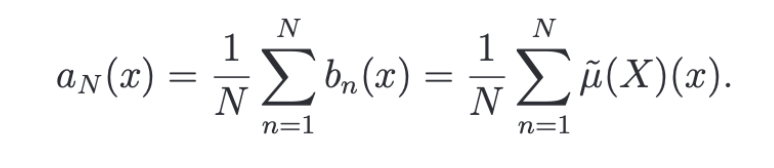

### Bagging bias

The bias of the composition obtained by bagging coincides with the bias of one basic algorithm.
Thus, bagging does not worsen the bias of the basic algorithm.

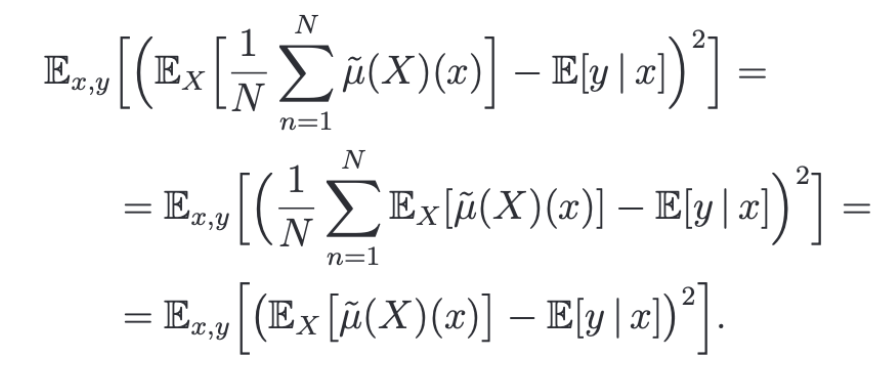

### Bagging variance

* The first term is the variance of one basic algorithm divided by the length of the composition $N$.

* The second is the covariance between the two basic algorithms. We see that if the basic algorithms are uncorrelated, then the variance of the composition is $N$ times less than the variance of individual algorithms. If there is a correlation, then the decrease in variance may be much less significant.

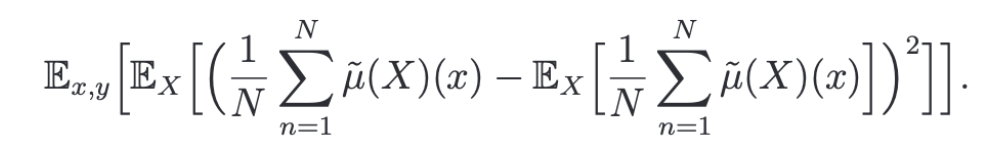

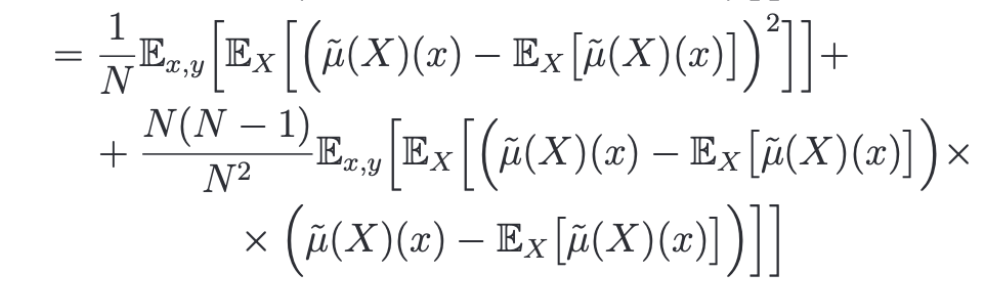

### Conclusion!

Bagging allows you to combine unbiased, but sensitive to the training sample algorithms into an unbiased
composition with low variance.

#### Task: simple voting

Suppose we have three binary classifiers, each of which is wrong with probability $p$. How likely is a classifier built with a simple voting wrong? At what values of $p$ will this probability be less than $p$?

#### Task: Out-Of-Bag
When bagging, a new selection of $\widetilde X$ is made by generating elements from $X$ with a return. In this case, objects in $\widetilde X$ can be repeated. We assume that the number of objects in $\widetilde X$ and in $X$ are the same and equal to $\ell$. Find the probability that a particular object will be included in the selection.

## Back to trees

In [3]:
%matplotlib inline
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import scipy.stats as ss

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

import matplotlib
import seaborn as sns

In [14]:
def plot_decision_surface(clf,
                          X: np.ndarray,
                          y: np.ndarray,
                          grid_step: float=0.02,
                          cmap='bwr',
                          alpha:float=0.6,
                          axes=None
        ):
    """
    Plot the decision surface of a classifier, visualize selected points
    Args:
      clf: a fitted model, must support predict method
      X[n_examples, n_features]: points where to evaluate the classifier
      y[n_examples]: true labels
      grid_step: decision surface plottting grid
      alpha: opacity of the decision surface
      axes(matplotlib.axes._subplots.AxesSubplot): axes where plot, if None, a new figure is created
    """

    # Define the grid
    x_top_left = X.min(axis=0) - 1
    x_bottom_right = X.max(axis=0) + 1
    grid_x0, grid_x1 = np.meshgrid(
         np.arange(x_top_left[0], x_bottom_right[0], grid_step),
         np.arange(x_top_left[1], x_bottom_right[1], grid_step)
      )

    # Calculate predictions on the grid
    y_pred_grid = clf.predict(
                        np.stack(
                              [
                                grid_x0.ravel(),
                                grid_x1.ravel()
                              ],
                              axis=1
                            )
                      ).reshape(grid_x1.shape)

    # Find optimal contour levels and make a filled
    # contour plot of predictions
    labels = np.sort(np.unique(y))
    labels = np.concatenate([[labels[0] - 1],
                             labels,
                             [labels[-1] + 1]])
    medians = (labels[1:] + labels[:-1]) / 2
    if axes is None:
        _, axes = plt.subplots()
    axes.contourf(grid_x0, grid_x1, y_pred_grid, cmap=cmap, alpha=alpha,
                 levels=medians)

    # Scatter data points on top of the plot,
    # with different styles for correct and wrong
    # predictions
    y_pred = clf.predict(X)
    axes.scatter(*X[y_pred==y].T, c=y[y_pred==y],
                marker='o', cmap=cmap, s=10, label='correct')
    axes.scatter(*X[y_pred!=y].T, c=y[y_pred!=y],
                marker='x', cmap=cmap, s=50, label='errors')

    # Dummy plot call to print the accuracy in the legend.
    axes.plot([], [], ' ',
             label='Accuracy = {:.3f}'.format(accuracy_score(y, y_pred)))
    axes.legend(loc='best')

#### Task: download data and split it into train and test

`Hint`: use np.load()

In [5]:
muticlass_toy_data = np.load(r'C:\Users\310\Desktop\Progects_Py\ML-course-at-ICEF\data\data.npz')
X, y = muticlass_toy_data["X"], muticlass_toy_data["y"]

X_toy_multiclass_train, X_toy_multiclass_test, \
  y_toy_multiclass_train, y_toy_multiclass_test = train_test_split(X, y, test_size=0.5)

In [6]:
assert X_toy_multiclass_train.shape == (2252, 2)
assert y_toy_multiclass_train.shape == (2252, )

#### Task 
Now it's your turn to investigate how the decision boundary depends on the tree depth. Maximum tree depth is defined by the max_depth parameter. Try out the following values: [1, 2, 3, 5, 10]. Make decision boundary plots for both train and test datasets (separately).

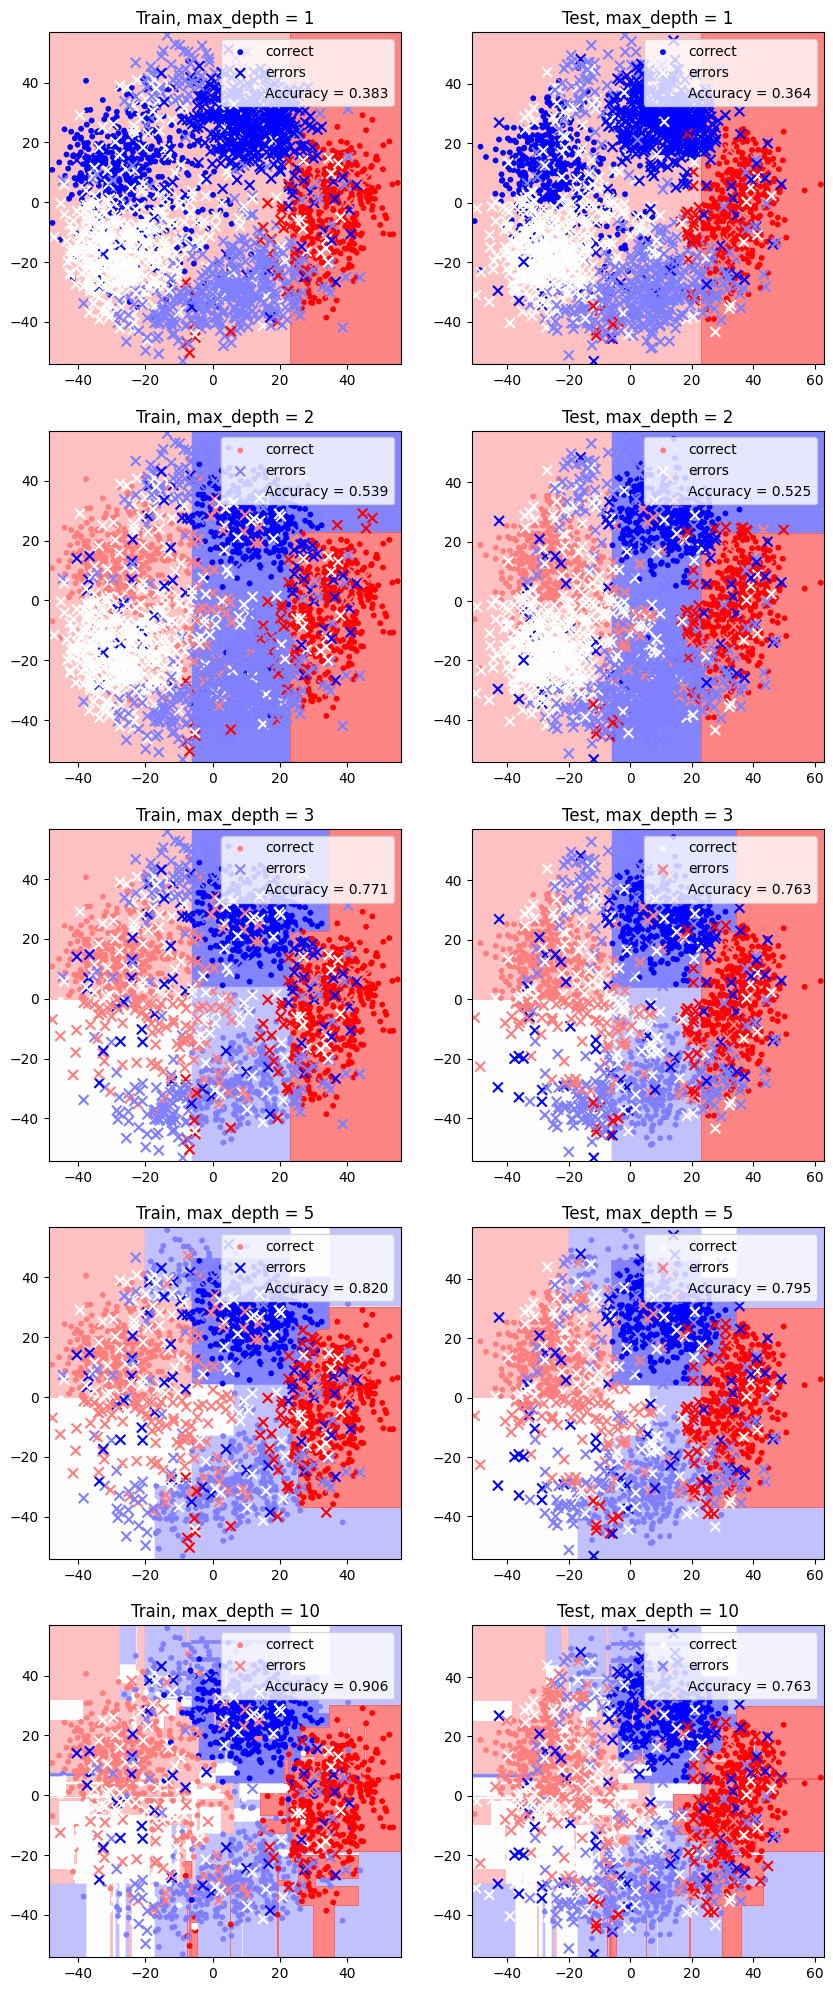

In [16]:
depth_values = [1, 2, 3, 5, 10]

fig, axes_matrix = plt.subplots(nrows=len(depth_values), ncols=2,
                                figsize=(2*5, 5*len(depth_values)))

for depth, (axes_train, axes_test) in zip(depth_values, axes_matrix):
    # Define and fit the classifier
    model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    model.fit(X_toy_multiclass_train, y_toy_multiclass_train)
    # Make decision plot with train data
    plot_decision_surface(model,
                          X_toy_multiclass_train,
                          y_toy_multiclass_train,
                          axes=axes_train
        )
    plot_decision_surface(model,
                          X_toy_multiclass_test,
                          y_toy_multiclass_test,
                          axes=axes_test
        )
    axes_train.set_title("Train, max_depth = {}".format(depth))
  
    # Make decision plot with test data

    axes_test.set_title("Test, max_depth = {}".format(depth))

#### Task

We need a better tree!

Try adjusting the parameters of DecisionTreeClassifier to improve the test accuracy for the multiclassification problem.

* Accuracy >= 0.72 - not bad for a start

* Accuracy >= 0.75 - better, but not enough

* Accuracy >= 0.77 - pretty good

* Accuracy >= 0.78 - great! (probably the best result for a single tree)

In [6]:
clf = pass
clf.fit(pass)

DecisionTreeClassifier(criterion='entropy', min_samples_leaf=15)

In [7]:
test_accuracy = accuracy_score(clf.predict(X_toy_multiclass_test), y_toy_multiclass_test)

In [15]:
assert test_accuracy >= 0.72

In [16]:
assert test_accuracy >= 0.75

In [17]:
assert test_accuracy >= 0.77

In [18]:
assert test_accuracy >= 0.78

#### Task: visualize tree
`Hint`: use plot_tree() function from sklearn

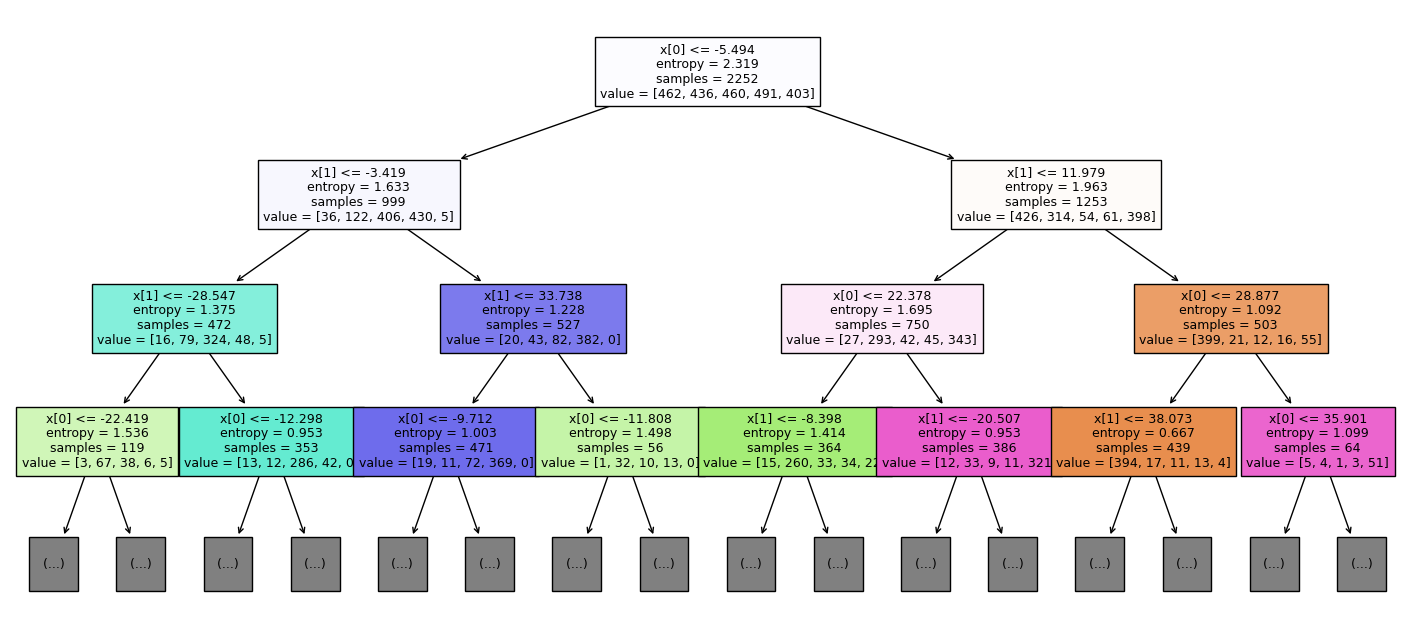

In [8]:
plt.figure(figsize=(18,8))

pass

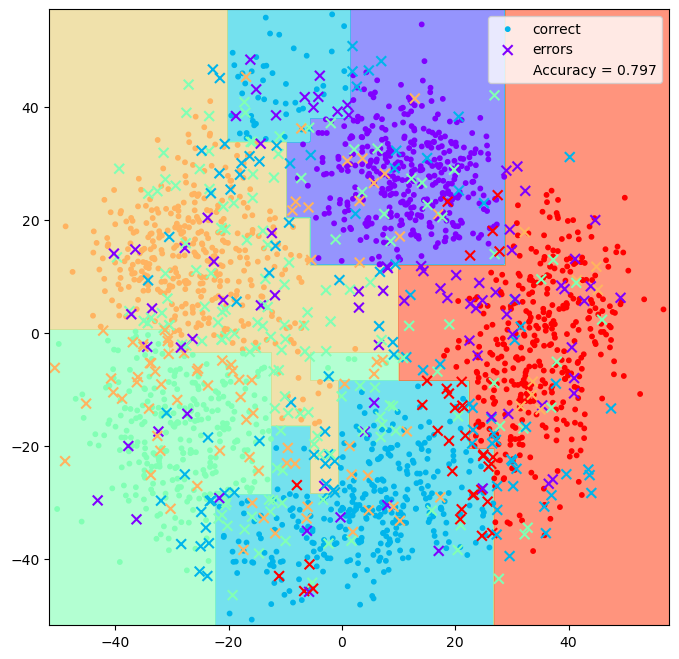

In [9]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_decision_surface(clf, X_toy_multiclass_test, y_toy_multiclass_test, cmap='rainbow', grid_step=0.2, axes=ax)

#### Task: plot feature importances for Decision Tree

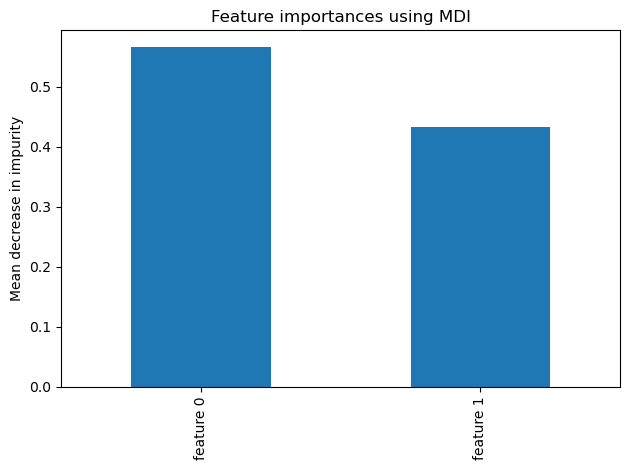

In [10]:
feature_names = [f"feature {i}" for i in range(X_toy_multiclass_train.shape[1])]

importances = pass
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()

pass

ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

#### Decision Trees

Key advantages:

* Interpretable results
* Not sensitive to data scaling
* Natural support for missing values and categorial data

Key disadvanatages:

* (comparatively) poor quality of the result
* Unstable training - small variations in the data might result in a completely different tree being generated

## Random Forests

Instead of training just one tree, let's do the following:
- Make $B$ bootstrap (sampling with replacement) samples from the training set.
- Fit a decision tree (deep) to each, obtaining $B$ trees $f_1, f_2, \dots, f_B$
    - every time we consider a split, **sample $m$ features** out of the total $p$, such that $m < p$, and **make the best split using these $m$ features**. In this way, we make our trees less correlated (**random subspace method**, also called attribute bagging or feature bagging)
    - for clasification problems: $m = \sqrt{p}$
    - for regression problems: $m = \frac{p}{3}$
- To predict, average the prediction of all trees: $\hat{y} = 1/B \sum_{i=0}^{B} f_i(x)$



The main things to tune for this model:
* `n_estimators` - number of trees,
* `max_samples` - number of samples in bootstrapped training set,
* `max_features` - number of features considered for a split,
* `max_depth` - max depth of trees.
Usually it's advised to keep it unlimited, but it can be beneficial to set a `max_depth` when you want to speed up the algorithm on large data or when the dataset contains a lot of noise.

The usual way is to select `n_estimators` and fix it, then tune the rest. The second most important is `max_features`, but you should tune it for some fixed `n_estimators`.

More info [here](https://dyakonov.org/2016/11/14/%D1%81%D0%BB%D1%83%D1%87%D0%B0%D0%B9%D0%BD%D1%8B%D0%B9-%D0%BB%D0%B5%D1%81-random-forest/)

Compared to boosting, the advantages are:
* Harder to overfit. Overfitting will not be made worse by adding more trees.
* Very easy to implement parallel training. If you ever have to do it by yourself for whatever reason...

Compared to boosting, the disadvantage is worse quality.

#### Task: fit Random Forest and plot its decision surface. How does it differ from the Decision Tree one?

In [19]:
# Note the n_jobs parameter: it defines the number of parallel training processes
# -1 means to use all available

pass

RandomForestClassifier(min_samples_leaf=5, n_jobs=-1, random_state=3421)

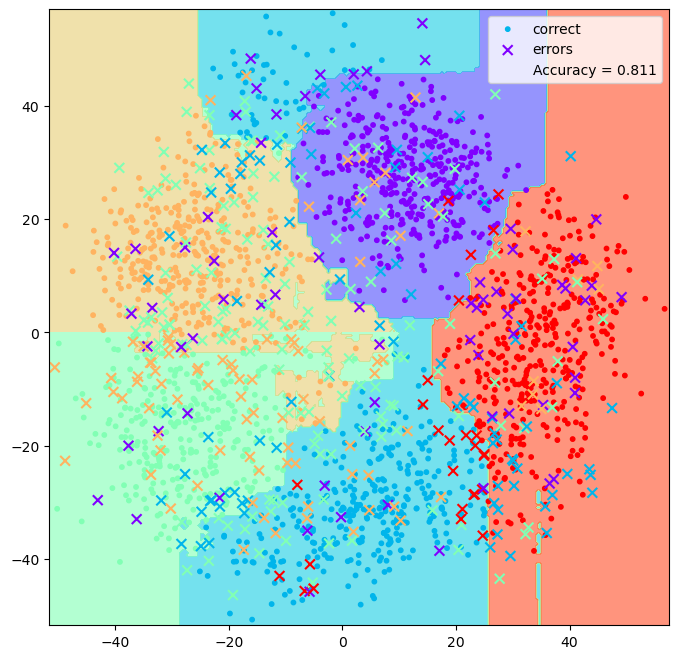

In [11]:
fig, ax = plt.subplots(figsize=(8, 8))

plot_decision_surface(random_forest,
                      X_toy_multiclass_test,
                      y_toy_multiclass_test,
                      cmap='rainbow', grid_step=0.4, axes=ax)

#### Task: plot feature importances with its standard deviation for Random Forest

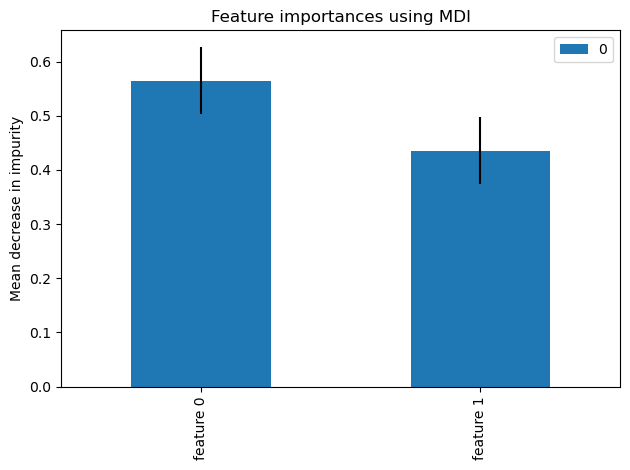

In [13]:
feature_names = [f"feature {i}" for i in range(X_toy_multiclass_train.shape[1])]

importances = pass
std = pass

forest_importances = pd.DataFrame(importances, index=feature_names)

fig, ax = plt.subplots()

pass

ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

# Trip down memory lane on statistics
*  Quality of an ML algorithm "in general" is hard to define and, in complete absense of assumptions on the data, all algorithms have the same performance - [no free lunch theorem](https://en.wikipedia.org/wiki/No_free_lunch_theorem)
*  Performance of a **particular** trained model on a **particular** test dataset is, however, a simple statistical problem you all are familiar with. Example loss is an i. i. d. random variable, algorithm performance is its expeted value, this is it.

#### Task
Compute the t-statistic and p-value and for hypothesis that random forest average accuracy is equal to decision tree accuracy on the `toy_multiclass_test` dataset
* for the whole test dataset
* for the subset consisting of the first 5 examples of the test dataset

`Hints:` 
- the definition of accuracy mean(predicted_label == real_label)
- T-test and its Python implementation: scipy.stats.ttest_ind

In [14]:
predictions_forest = random_forest.predict(X_toy_multiclass_test)

predictions_tree = DecisionTreeClassifier(random_state=234).fit(
    X_toy_multiclass_train, y_toy_multiclass_train).predict(X_toy_multiclass_test)

In [15]:
# For the benefit of the checker, please store the results in the following variables:
# full_test_p_value and test_5_p_value

pass

/var/folders/gv/k52rb94x2m54mddyj3df24880000gq/T/ipykernel_2934/3561058685.py:9: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat_5, test_5_p_value = ss.ttest_ind(forest[:5], tree[:5])


In [16]:
print(full_test_p_value, test_5_p_value)

5.327000582272535e-17 0.3465935070873342


In [17]:
# The actual p-values you'll see are likely to be lower and higher respectively.
# The assertion boundaries are very permissinve to account for possible fluctuations.
assert(full_test_p_value < 1e-12)
assert(test_5_p_value > 1e-2)

In [18]:
alpha = 0.05

assert(full_test_p_value < alpha)
assert(test_5_p_value > alpha)